In [1]:
from unityagents import UnityEnvironment
from collections import deque
import numpy as np
import torch

import datetime;

import json

config = json.load(open('config.json'))

In [2]:
env = UnityEnvironment(file_name='Reacher_Windows_x86_64_multi/Reacher.exe',no_graphics=True, seed = config['SEED']['environment'])
#,no_graphics=True

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.58052063e-01 -1.00000000e+00
 -7.98051453e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  5.63595533e-01]


In [5]:
from agent_ddpg import Agent

print(config)
agent = Agent(state_size, action_size, config['SEED']['agent'])
print(agent.actor_local)
print(agent.critic_local)


{'TAU': 0.001, 'LR_CRITIC': 0.0001, 'LR_ACTOR': 0.0001, 'GAMMA': 0.99, 'BUFFER_SIZE': 400000, 'BATCH_SIZE': 256, 'WEIGHT_DECAY': 0, 'NOISE_SIGMA': 0.1, 'SEED': {'environment': 10, 'agent': 42}, 'NETWORK': {'dropout': 0.2}}
Actor(
  (fc1): Linear(in_features=33, out_features=256, bias=True)
  (batch): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)
Critic(
  (fc1): Linear(in_features=33, out_features=256, bias=True)
  (batch): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=260, out_features=128, bias=True)
  (dropout): Dropout(p=0.2)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)


In [6]:

episodes = 1000
scores = []
scores_window = deque(maxlen=100)
avg_scores = []
avg_scores.append(0)
avg = []
for episode in range(1, episodes+1): 
    env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    agent.reset();
    ep_scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    start = datetime.datetime.now()
    while True:
        actions = agent.act(states) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                        # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        ep_scores += env_info.rewards                         # update the score (for each agent)
    
        [agent.step(states[i], actions[i], rewards[i], next_states[i], dones[i]) for i in range(num_agents)]
        
        agent.step_learn()
        
    
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    took = datetime.datetime.now() -start
    scores.append(np.mean(ep_scores))
    scores_window.append(np.mean(ep_scores))
    avg_score = np.mean(scores_window)
    print('Total score (averaged over agents) this episode\t{}:\t{:.4f}\tAverage Score:\t{:.4f}\ttime: {:s}'.format(episode, np.mean(ep_scores), avg_score, str(took)))
    
    if episode % 100 == 0:        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode,avg_score))
        avg_scores.append(avg_score)
        torch.save(agent.actor_local.state_dict(), 'checkpoint_{:d}_actor.pth'.format(episode))
        torch.save(agent.critic_local.state_dict(), 'checkpoint_{:d}_critic.pth'.format(episode))
    if avg_score >= 30.0:
        print()
        print('solved in Episode {}', episode)
        torch.save(agent.actor_local.state_dict(), 'solved_{:d}_actor_local.pth'.format(episode))
        torch.save(agent.critic_local.state_dict(), 'solved_{:d}_critic_local.pth'.format(episode))
        
torch.save(agent.actor_local.state_dict(), 'end_actor_local.pth')
torch.save(agent.critic_local.state_dict(), 'end_critic_local.pth')
        

Total score (averaged over agents) this episode	1:	0.6525	Average Score:	0.6525	time: 0:00:32.499360
Total score (averaged over agents) this episode	2:	0.9505	Average Score:	0.8015	time: 0:00:32.607362
Total score (averaged over agents) this episode	3:	0.9245	Average Score:	0.8425	time: 0:00:32.389336
Total score (averaged over agents) this episode	4:	0.7280	Average Score:	0.8139	time: 0:00:32.295639
Total score (averaged over agents) this episode	5:	0.3555	Average Score:	0.7222	time: 0:00:33.282524
Total score (averaged over agents) this episode	6:	0.3130	Average Score:	0.6540	time: 0:00:33.945194
Total score (averaged over agents) this episode	7:	0.2075	Average Score:	0.5902	time: 0:00:34.473281
Total score (averaged over agents) this episode	8:	0.1790	Average Score:	0.5388	time: 0:00:33.669337
Total score (averaged over agents) this episode	9:	0.1345	Average Score:	0.4939	time: 0:00:32.816918
Total score (averaged over agents) this episode	10:	0.1705	Average Score:	0.4615	time: 0:00

In [7]:
env.close()

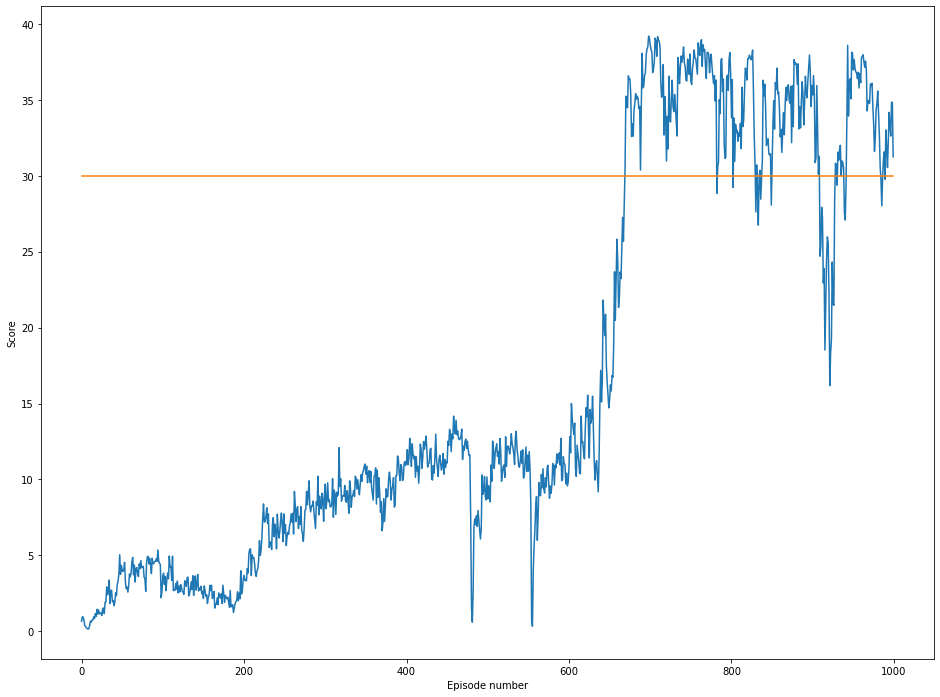

In [10]:
import matplotlib.pyplot as plt

# plot the scores
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(len(scores)), 30*np.ones(len(scores)))
plt.xlabel('Episode number')
plt.ylabel('Score')
plt.show()

[0, 2.842974936454557, 2.7039049395630137, 6.763404848826118, 9.449074788796715, 10.790829758806156, 10.366679768286645, 21.9465845094556, 36.37992418684531, 34.16415923637152, 31.737129290619865]


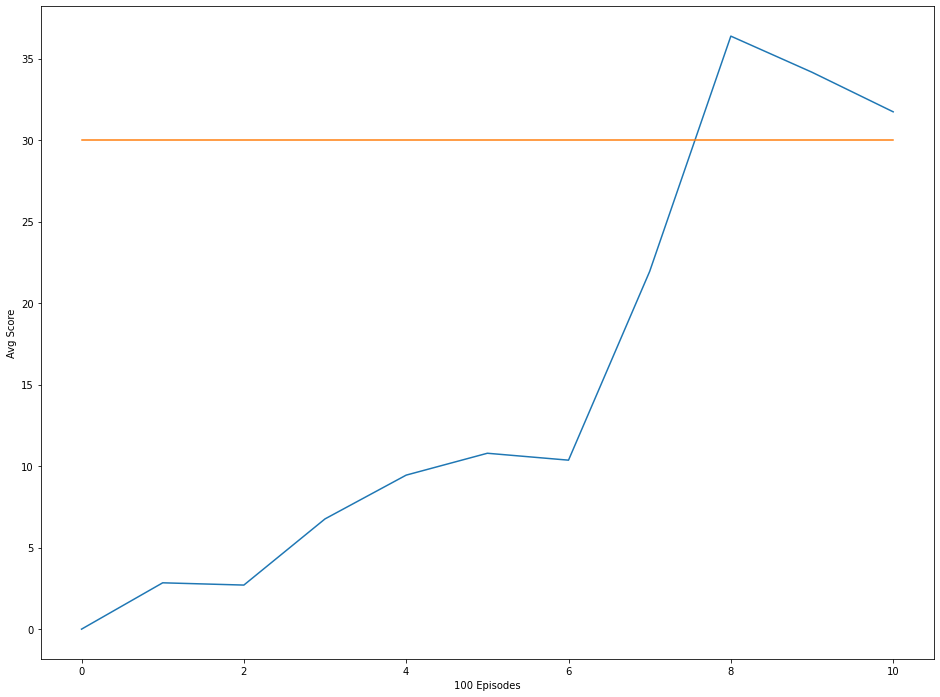

In [11]:
print(avg_scores)
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(avg_scores)), avg_scores)
plt.plot(np.arange(len(avg_scores)), 30*np.ones(len(avg_scores)))
plt.xlabel('100 Episodes')
plt.ylabel('Avg Score')
plt.show()